## RL for Predictive Maintenance 
- Using SIT data
- Tested with Case-1, 200 records
- 30-Aug: Attention Mechanism added

### Imports

In [1]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import os
from typing import Tuple, Dict, Any, List

### Global settings

In [2]:
# --- Global Parameters ---
# These can be easily modified for experimentation.

# Data and Environment settings
IOT_FILE = 'AM_Code'
DATA_FILE = 'data\SIT_200.csv' # 'data\Case_1_1K_Data.csv'
TEST_FILE = 'SIT_84.csv'
WEAR_THRESHOLD = 290.0  # Threshold for tool wear before it's considered failed

# Reward structure
R1_CONTINUE = 2.0      # Reward for continuing with a healthy tool
R2_REPLACE = -5.0      # Reward for a timely replacement
R3_VIOLATION = -30.0   # Penalty for violating the wear threshold

# Training settings
EPISODES = 500          # Total number of episodes to train each agent
LEARNING_RATE = 5e-3    # Learning rate for optimizers
GAMMA = 0.99            # Discount factor for future rewards

# Plotting settings
SMOOTH_WINDOW = 50      # Window size for moving average smoothing on plots

# Model saving
SAVE_MODEL = False
REINFORCE_MODEL_FILE = f'models/{IOT_FILE}_REINFORCE_Model.h5'
PPO_MODEL_FILE = f'models/{IOT_FILE}_PPO_Model.zip'  # PPO uses .zip extension by default


### Plotting

In [3]:
# --- Task 4: Plotting the Comparison ---

def smooth(data: List[float], window_size: int) -> np.ndarray:
    """
    Applies a simple moving average to a list of data.
    Handles NaNs by ignoring them in the window calculation.
    """
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().to_numpy()

def plot_metrics(reinforce_metrics: Dict, ppo_metrics: Dict, window: int, mode: str = "COMBINED"):
    """
    Generates performance metric plots either combined or separate.
    
    Args:
        reinforce_metrics (Dict): Dictionary containing REINFORCE metrics
        ppo_metrics (Dict): Dictionary containing PPO metrics
        window (int): Window size for smoothing the curves
        mode (str): Either "COMBINED" or "SEPARATE" for plotting style
    """
    W, H = 16, 6
    FONTSIZE_SUPER = 18
    FONTSIZE_TITLE = 12
    FONTSIZE_LABEL = 10
    FONTSIZE_TICK = 9
    BACKGROUND_COLOR = '#f8f8f8'  # Lighter grey background
    
    def setup_subplot(ax, title, xlabel, ylabel):
        """Helper function to set up common subplot properties"""
        ax.set_title(title, fontsize=FONTSIZE_TITLE)
        ax.set_xlabel(xlabel, fontsize=FONTSIZE_LABEL)
        ax.set_ylabel(ylabel, fontsize=FONTSIZE_LABEL)
        ax.tick_params(labelsize=FONTSIZE_TICK)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_facecolor(BACKGROUND_COLOR)
    
    # Get data ranges for consistent y-axis limits
    def get_data_ranges(metrics_config):
        ranges = {}
        for config in metrics_config:
            key = config['data']
            if key == 'margins':
                r_data = pd.Series(reinforce_metrics[key]).rolling(window, min_periods=1).mean()
                p_data = pd.Series(ppo_metrics[key]).rolling(window, min_periods=1).mean()
            else:
                r_data = smooth(reinforce_metrics[key], window)
                p_data = smooth(ppo_metrics[key], window)
            
            all_data = np.concatenate([r_data, p_data])
            ranges[key] = (np.nanmin(all_data), np.nanmax(all_data))
        return ranges
        
    if mode.upper() == "COMBINED":
        # Create single figure with both algorithms
        fig, axs = plt.subplots(2, 2, figsize=(W, H))
        fig.suptitle('REINFORCE vs. PPO Performance for Predictive Maintenance', fontsize=FONTSIZE_SUPER)
        
        # Plot all metrics with both algorithms
        metrics_config = [
            {'data': 'rewards', 'title': 'Learning Curve (Smoothed Average Reward)', 
             'ylabel': 'Average Reward'},
            {'data': 'replacements', 'title': 'Replacements per episode (Smoothed)', 
             'ylabel': 'Replacement Rate'},
            {'data': 'violations', 'title': 'Threshold Violations per episode (Smoothed)', 
             'ylabel': 'Violation Rate'},
            {'data': 'margins', 'title': 'Wear Margin Before Replacement (Smoothed)', 
             'ylabel': 'Wear Margin'}
        ]
        
        for idx, config in enumerate(metrics_config):
            ax = axs[idx // 2, idx % 2]
            if config['data'] == 'margins':
                r_data = pd.Series(reinforce_metrics[config['data']]).rolling(window, min_periods=1).mean()
                p_data = pd.Series(ppo_metrics[config['data']]).rolling(window, min_periods=1).mean()
            else:
                r_data = smooth(reinforce_metrics[config['data']], window)
                p_data = smooth(ppo_metrics[config['data']], window)
                
            ax.plot(r_data, label='REINFORCE', alpha=0.6)
            ax.plot(p_data, label='PPO', alpha=0.6)
            setup_subplot(ax, config['title'], 'Episode', config['ylabel'])
            ax.legend()
        
    else:  # SEPARATE mode
        # First calculate data ranges for consistent scaling
        metrics_config = [
            {'data': 'rewards', 'color': 'blue', 'title': 'Learning Curve (Smoothed Average Reward)', 
             'ylabel': 'Average Reward'},
            {'data': 'replacements', 'color': 'green', 'title': 'Replacements per episode (Smoothed)', 
             'ylabel': 'Replacement Rate'},
            {'data': 'violations', 'color': 'red', 'title': 'Threshold Violations per episode (Smoothed)', 
             'ylabel': 'Violation Rate'},
            {'data': 'margins', 'color': 'purple', 'title': 'Wear Margin Before Replacement (Smoothed)', 
             'ylabel': 'Wear Margin'}
        ]
        data_ranges = get_data_ranges(metrics_config)
        
        # Create separate figures for each algorithm
        for algo, metrics in [("REINFORCE", reinforce_metrics), ("PPO", ppo_metrics)]:
            fig, axs = plt.subplots(2, 2, figsize=(W, H))
            fig.patch.set_facecolor(BACKGROUND_COLOR)  # Set figure background
            fig.suptitle(f'{algo} Performance Metrics for Predictive Maintenance', fontsize=FONTSIZE_SUPER)
            
            for idx, config in enumerate(metrics_config):
                ax = axs[idx // 2, idx % 2]
                if config['data'] == 'margins':
                    data = pd.Series(metrics[config['data']]).rolling(window, min_periods=1).mean()
                else:
                    data = smooth(metrics[config['data']], window)
                    
                ax.plot(data, color=config['color'], alpha=0.6)
                setup_subplot(ax, config['title'], 'Episode', config['ylabel'])
                
                # Set consistent y-axis limits
                ymin, ymax = data_ranges[config['data']]
                padding = (ymax - ymin) * 0.1  # Add 10% padding
                # ax.set_ylim(ymin - padding, ymax + padding)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def plot_metrics_RF_AM (reinforce_metrics: Dict, attention_metrics: Dict, window: int, mode: str ="COMBINED"):
    """
    Generates performance metric plots either combined or separate.

    Args:
    reinforce_metrics (Dict): Dictionary containing REINFORCE metrics
    attention_metrics (Dict): Dictionary containing attention_metrics
    window (int): Window size for smoothing the curves
    mode (str): Either "COMBINED" or "SEPARATE" for plotting style
    """
    W, H = 16, 6
    FONTSIZE_SUPER = 18
    FONTSIZE_TITLE = 12
    FONTSIZE_LABEL = 10
    FONTSIZE_TICK = 9
    BACKGROUND_COLOR = '#f8f8f8' # Lighter grey background

    def setup_subplot(ax, title, xlabel, ylabel):
        """Helper function to set up common subplot properties"""
        ax.set_title(title, fontsize=FONTSIZE_TITLE)
        ax.set_xlabel(xlabel, fontsize=FONTSIZE_LABEL)
        ax.set_ylabel(ylabel, fontsize=FONTSIZE_LABEL)
        ax.tick_params(labelsize=FONTSIZE_TICK)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_facecolor(BACKGROUND_COLOR)

    # Get data ranges for consistent y-axis limits
    def get_data_ranges(metrics_config):
        ranges = {}
        for config in metrics_config:
            key = config['data']
            if key == 'margins':
                r_data = pd.Series(reinforce_metrics[key]).rolling(window, min_periods=1).mean()
                p_data = pd.Series(attention_metrics[key]).rolling(window, min_periods=1).mean()
            else:
                r_data = smooth(reinforce_metrics[key], window)
                p_data = smooth(attention_metrics[key], window)

            all_data = np.concatenate([r_data, p_data])
            ranges[key]= (np.nanmin(all_data), np.nanmax(all_data))
        return ranges

    # Create single figure with both algorithms
    fig, axs = plt.subplots(2, 2, figsize=(W, H))
    fig.suptitle('REINFORCE performance - without and with attention', fontsize=FONTSIZE_SUPER)

    # Plot all metrics with both algorithms
    metrics_config = [
        {'data': 'rewards', 'title': 'Learning Curve (Smoothed Average Reward)',
            'ylabel': 'Average Reward'},
        {'data': 'replacements', 'title': 'Replacements per episode (Smoothed)',
            'ylabel': 'Replacement Rate'},
        {'data': 'violations', 'title': 'Threshold Violations per episode (Smoothed)',
            'ylabel': 'Violation Rate'},
        {'data': 'margins', 'title': 'Wear Margin Before Replacement (Smoothed)',
            'ylabel': 'Wear Margin'}
    ]

    for idx, config in enumerate(metrics_config):
        ax = axs[idx // 2, idx % 2]
        if config['data'] == 'margins':
            r_data = pd.Series(reinforce_metrics[config['data']]).rolling(window, min_periods=1).mean()
            p_data = pd.Series(attention_metrics[config['data']]).rolling(window, min_periods=1).mean()
        else:
            r_data = smooth(reinforce_metrics[config['data']], window)
            p_data = smooth(attention_metrics[config['data']], window)

        ax.plot(r_data, label='Raw sensor', alpha=0.6, color='tab:blue')
        ax.plot(p_data, label='+ Attention', alpha=0.6, color='tab:red')
        setup_subplot(ax, config['title'], 'Episode', config['ylabel'])
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### Custom RL Environment for milling tool maintenance
- OpenAI's Gymnasium open standards format

In [4]:
# --- Task 1: Custom Gymnasium Environment ---
# We define the environment for the milling tool maintenance problem.

class MT_Env(gym.Env):
    """
    Custom Gymnasium environment for Milling Tool Predictive Maintenance.

    The agent observes the current tool wear and decides whether to continue
    using the tool or replace it.

    Observation Space: A single continuous value representing the current tool wear.
    Action Space: Two discrete actions - 0 (CONTINUE) or 1 (REPLACE_TOOL).
    """
    metadata = {'render_modes': ['human']}

    def __init__(self, data_file: str, wear_threshold: float, r1: float, r2: float, r3: float):
        """
        Initializes the environment.

        Args:
            data_file (str): Path to the CSV file with sensor data and tool wear.
            wear_threshold (float): The maximum allowable tool wear.
            r1 (float): Reward for continuing.
            r2 (float): Reward for a timely replacement.
            r3 (float): Penalty for a threshold violation.
        """
        super(MT_Env, self).__init__()

        # Load and preprocess data
        if not os.path.exists(data_file):
            raise FileNotFoundError(f"Data file not found at {data_file}. Please ensure the file is in the correct directory.")
        self.df = pd.read_csv(data_file)
        self.max_steps = len(self.df) - 1

        # Environment parameters
        self.wear_threshold = wear_threshold
        self.r1_continue = r1
        self.r2_replace = r2
        self.r3_violation = r3

        # Define action and observation spaces
        self.action_space = spaces.Discrete(2)  # 0: CONTINUE, 1: REPLACE_TOOL
        # The observation is the current tool wear, normalized for better learning
        self.observation_space = spaces.Box(low=0, high=self.wear_threshold * 1.5, shape=(1,), dtype=np.float32)

        # Internal state
        self.current_step = 0

    def reset(self, seed=None, options=None) -> Tuple[np.ndarray, Dict]:
        """
        Resets the environment to its initial state for a new episode.
        """
        super().reset(seed=seed)
        self.current_step = 0
        initial_observation = self._get_observation()
        return initial_observation, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """
        Executes one time step within the environment.
        """
        terminated = False
        truncated = False
        reward = 0
        info = {'violation': False, 'replacement': False, 'margin': np.nan}

        current_wear = self.df.loc[self.current_step, 'tool_wear']

        if action == 1:  # Action: REPLACE_TOOL
            reward = self.r2_replace
            terminated = True
            info['replacement'] = True
            info['margin'] = self.wear_threshold - current_wear
        elif action == 0:  # Action: CONTINUE
            self.current_step += 1
            if self.current_step > self.max_steps:
                # Reached the end of data without replacement or violation
                truncated = True
                reward = 0 # No reward or penalty if data runs out
            else:
                next_wear = self.df.loc[self.current_step, 'tool_wear']
                if next_wear >= self.wear_threshold:
                    reward = self.r3_violation
                    terminated = True
                    info['violation'] = True
                    # $$$ Avoid NANs for margin. Even if NOT replaced, see what the margin is
                    info['margin'] = self.wear_threshold - current_wear
                else:
                    reward = self.r1_continue
        
        observation = self._get_observation()
        
        return observation, reward, terminated, truncated, info

    def _get_observation(self) -> np.ndarray:
        """
        Gets the current observation from the dataframe.
        """
        wear = self.df.loc[self.current_step, 'tool_wear']
        return np.array([wear], dtype=np.float32)

    def render(self, mode='human'):
        """
        Renders the environment state (optional, for visualization).
        """
        wear = self.df.loc[self.current_step, 'tool_wear']
        print(f"Step: {self.current_step}, Tool Wear: {wear:.2f}")


class AM_Env(MT_Env):
    """
        Attention-augmented variant of MT_Env.

        - Uses the same sensor features as the dataset.
        Computes attention weights via KernelRidge(kernel='linear') fitted to features -> tool_wear,
        The primal coefficients are used to derive per-feature importances (absolute value, normalized).
        - Observation returned is the normalized feature vector multiplied elementwise by attention weights.
    """

    def _init_(self, data_file: str, wear_threshold: float, r1: float, r2: float, r3: float, kr_alpha: float = 1.0):
        super(AM_Env, self).__init__(data_file, wear_threshold, r1, r2, r3)

        # feature list (same as suggested earlier)
        self.features = ['vib_Spindle', 'Vib_Table', 'Sound_Spindle', 'Sound_table', 'X_Load_Cell', 'Y_Load_Cell', 'Z_Load_Cell', 'Current']

        # ensure features exist
        missing = [f for f in self.features if f not in self.df.columns]
        if missing:
            raise ValueError(f"Missing features in dataset: {missing}")

        # compute per-feature normalization stats
        vals_df = self.df[self.features].astype(np.float32)
        self.feature_means = vals_df.mean(axis=0).to_numpy(dtype=np.float32)
        self.feature_stds = vals_df.std(axis=0).replace(0, 1.0).to_numpy(dtype=np.float32)

        # prepare training data for KernelRidge
        X = (vals_df - self.feature_means) / (self.feature_stds + 1e-9)
        x = x.to_numpy(dtype=np.float32)
        y = self.df['tool_wear'].to_numpy(dtype=np.float32)

        # fit KernelRidge (linear) to estimate feature importances
        try:
            from sklearn.kernel_ridge import KernelRidge
        except Exception as e:
            raise ImportError("scikit-learn is required for AM_Env. Install with `pip install scikit-learn") from e

        self._kr_model = KernelRidge(kernel='linear', alpha=kr_alpha)
        self._kr_model.fit(X, y)

        # compute primal coefficients from dual_coef_ and x_fit_
        # coef = x_fit _. T @ dual_coef_ (shape: n_features,)
        dual=np.asarray(self._kr_model.dual_coef_).reshape(-1, 1) # (n_train, 1)
        x_fit = np.asarray(self._kr_model.x_fit_) # (n_train, n_features)
        coef = (x_fit.T @ dual).ravel() # (n_features,)

        attn = np.abs(coef)
        if attn.sum() == 0:
            attn = np.ones_like(attn)
        attn = attn / (attn.sum() + 1e-12)
        self.attention_weights = attn.astype(np.float32)

        # observation space: attention-weighted feature vector
        self.observation_space = spaces.Box(low =- np.inf, high=np.inf, shape=(len(self.features),), dtype=np.float32)

    def get_observation(self) -> np.ndarray:
        """Return the attention-weighted, normalized feature vector for current step."""
        vals = self.df.loc[self.current_step, self.features].to_numpy(dtype=np.float32)
        norm = (vals - self.feature_means) / (self.feature_stds + 1e-9)
        weighted = norm * self.attention_weights
        return weighted.astype(np.float32)
    
    def recompute_attention(self, window: int = None, kr_alpha: float = None):
        """
            Optionally recompute attention weights:
            - If window'is None -> use full dataset (same as init).
            - If window is int -> use last 'window rows up to current_step to compute local attention.
            - kr_alpha overrides regularization when refitting.
        """
        
        if window is None:
            df_slice = self.df[self.features]
        else:
            start = max(0, self.current_step - window + 1)
            df_slice = self.df.loc[start:self.current_step, self.features]
            if len(df_slice) < 2:
                df_slice = self.df[self.features] # fallback to full data if slice too small

        x = ((df_slice - self.feature_means) / (self.feature_stds + 1e-9)).to_numpy(dtype=np.float32)
        y = self.df.loc[df_slice.index, 'tool_wear'].to_numpy(dtype=np.float32)

        from sklearn.kernel_ridge import KernelRidge
        model = KernelRidge(kernel='linear', alpha=(kr_alpha if kr_alpha is not None else self._kr_model.alpha))
        model.fit(x, y)
        dual = np.asarray(model.dual_coef_).reshape(-1, 1)
        x_fit = np.asarray(model.x_fit )
        coef = (x_fit.T @ dual).ravel()
        attn = np.abs(coef)
        if attn.sum() == 0:
            attn = np.ones_like(attn)
        attn = attn / (attn.sum() + 1e-12)
        self.attention_weights = attn.astype(np.float32)

### REINFORCE Algorithm Implementation
- Custom implementation of the REINFORCE algorithm
- Employs OpenAI's Stable Baselines3 open-source standards for wider research adoption

In [5]:
# --- Task 2: REINFORCE Algorithm Implementation ---
# A custom implementation of the REINFORCE algorithm with a structure
# similar to Stable Baselines3 for easy comparison.
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return self.net(x)

class REINFORCE:
    """
    A custom REINFORCE agent.
    """
    def __init__(self, policy, env, learning_rate=0.001, gamma=0.99, model_file=None):
        self.env = env
        self.policy = policy
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.model_name = "REINFORCE"
        self.model_file = model_file

    def predict(self, obs: np.ndarray) -> int:
        """
        Selects an action based on the current observation.
        Uses the same action selection logic as training for consistency.
        """
        with torch.no_grad():  # Important to disable gradients for prediction
            state_tensor = torch.FloatTensor(obs).unsqueeze(0)
            probs = self.policy(state_tensor)
            dist = Categorical(probs)
            action = dist.sample()  # Sample action like in training
            return action.item()        

    def learn(self, total_episodes: int) -> Dict[str, List]:
        """
        Trains the agent for a given number of episodes.
        """
        print(f"--- Training {self.model_name} ---")
        # Metrics collectors
        all_rewards = []
        all_violations = []
        all_replacements = []
        all_margins = []

        for episode in range(total_episodes):
            log_probs = []
            rewards = []
            obs, _ = self.env.reset()
            done = False
            
            episode_info = {'violation': 0, 'replacement': 0, 'margin': np.nan}

            while not done:
                state_tensor = torch.FloatTensor(obs).unsqueeze(0)
                probs = self.policy(state_tensor)
                dist = Categorical(probs)
                action = dist.sample()

                log_prob = dist.log_prob(action)
                log_probs.append(log_prob)

                obs, reward, terminated, truncated, info = self.env.step(action.item())
                rewards.append(reward)
                done = terminated or truncated

                if info.get('violation'): episode_info['violation'] = 1
                if info.get('replacement'): episode_info['replacement'] = 1
                if not np.isnan(info.get('margin')): episode_info['margin'] = info.get('margin')
            
            # Collect metrics for this episode
            all_rewards.append(sum(rewards))
            all_violations.append(episode_info['violation'])
            all_replacements.append(episode_info['replacement'])
            all_margins.append(episode_info['margin'])

            # Calculate discounted returns
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + self.gamma * G
                returns.insert(0, G)
            returns = torch.tensor(returns, dtype=torch.float32)
            
            # Normalize returns for stability, but only if there's more than one step
            # to avoid std() of a single item becoming NaN.
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-9)

            # Calculate policy loss and update weights
            policy_loss = []
            for log_prob, G in zip(log_probs, returns):
                policy_loss.append(-log_prob * G)
            
            self.optimizer.zero_grad()
            policy_loss = torch.cat(policy_loss).sum()
            policy_loss.backward()
            self.optimizer.step()

            if (episode + 1) % 50 == 0:
                print(f"Episode {episode + 1}/{total_episodes}, Total Reward: {sum(rewards):.2f}")
        
        print("--- Training Complete ---")
        
        # Save model if file path was provided
        if self.model_file is not None:
            try:
                # Create directory if it doesn't exist
                os.makedirs(os.path.dirname(self.model_file), exist_ok=True)
                # Save the model
                torch.save({
                    'policy_state_dict': self.policy.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'input_dim': self.policy.net[0].in_features,
                    'output_dim': self.policy.net[-2].out_features
                }, self.model_file)
                print(f"Model saved successfully to: {self.model_file}")
            except Exception as e:
                print(f"Error saving model: {str(e)}")

        return {
            "rewards": all_rewards,
            "violations": all_violations,
            "replacements": all_replacements,
            "margins": all_margins
        }


### Test saved RL agent

In [6]:
# def test_saved_model(model_file: str, test_data_file: str, wear_threshold: float, r1: float, r2: float, r3: float):
#     """
#     Tests a saved model on new sensor data and visualizes the results.
    
#     Args:
#         model_file (str): Path to the saved model file
#         test_data_file (str): Path to the new sensor data file
#         wear_threshold (float): Threshold for tool wear
#         r1, r2, r3 (float): Reward parameters for the environment
#     """
#     # Create test environment
#     test_env = MT_Env(
#         data_file=test_data_file,
#         wear_threshold=wear_threshold,
#         r1=r1, r2=r2, r3=r3
#     )
    
#     # Load the model
#     policy = PolicyNetwork(
#         input_dim=test_env.observation_space.shape[0],
#         output_dim=test_env.action_space.n
#     )
#     agent = REINFORCE(policy, test_env)
    
#     try:
#         checkpoint = torch.load(model_file)
#         agent.policy.load_state_dict(checkpoint['policy_state_dict'])
#         print(f"Model loaded successfully from: {model_file}")
#     except Exception as e:
#         print(f"Error loading model: {str(e)}")
#         return
    
#     # Test metrics
#     total_steps = 0
#     total_replacements = 0
#     total_violations = 0
#     margins = []
#     replacement_points = []
#     violation_points = []
#     wear_trajectory = []
    
#     # Run test episode
#     obs, _ = test_env.reset()
#     done = False
#     step = 0
    
#     while not done:
#         action = agent.predict(obs)
#         obs, reward, terminated, truncated, info = test_env.step(action)
#         wear = obs[0]
#         wear_trajectory.append(wear)
        
#         if info.get('replacement'):
#             total_replacements += 1
#             replacement_points.append((step, wear))
#             margins.append(wear_threshold - wear)
        
#         if info.get('violation'):
#             total_violations += 1
#             violation_points.append((step, wear))
#             margins.append(wear_threshold - wear)
        
#         step += 1
#         done = terminated or truncated
    
#     total_steps = step
    
#     # Calculate metrics
#     metrics = {
#         'total_steps': total_steps,
#         'replacement_rate': total_replacements / total_steps,
#         'violation_rate': total_violations / total_steps,
#         'avg_margin': np.mean(margins) if margins else np.nan,
#         'min_margin': np.min(margins) if margins else np.nan
#     }
    
#     # Plotting
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
#     fig.suptitle('Model Test Results', fontsize=11)
    
#     # Plot 1: Wear trajectory with events
#     ax1.plot(wear_trajectory, 'b-', alpha=0.6, label='Tool Wear')
#     ax1.axhline(y=wear_threshold, color='r', linestyle='--', alpha=0.6, label='Wear Threshold')
    
#     # Plot replacement and violation points
#     if replacement_points:
#         points = np.array(replacement_points)
#         ax1.scatter(points[:, 0], points[:, 1], color='g', marker='^', 
#                 label='Replacements', alpha=0.6)
#     if violation_points:
#         points = np.array(violation_points)
#         ax1.scatter(points[:, 0], points[:, 1], color='r', marker='x', 
#                 label='Violations', alpha=0.6)
    
#     ax1.set_title('Tool Wear Trajectory')
#     ax1.set_xlabel('Step')
#     ax1.set_ylabel('Wear')
#     ax1.grid(True, alpha=0.3)
#     ax1.legend()
    
#     # Plot 2: Margins histogram
#     if margins:
#         ax2.hist(margins, bins=20, alpha=0.6, color='purple')
#         ax2.axvline(x=0, color='r', linestyle='--', alpha=0.6)
#         ax2.set_title('Distribution of Margins at Decision Points')
#         ax2.set_xlabel('Margin (Threshold - Wear)')
#         ax2.set_ylabel('Frequency')
#         ax2.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print metrics
#     print("\nTest Results:")
#     print(f"Total Steps: {metrics['total_steps']}")
#     print(f"Replacement Rate: {metrics['replacement_rate']:.4f}")
#     print(f"Violation Rate: {metrics['violation_rate']:.4f}")
#     print(f"Average Margin: {metrics['avg_margin']:.2f}")
#     print(f"Minimum Margin: {metrics['min_margin']:.2f}")
    
#     return metrics

def test_saved_model(
    model_file: str, 
    test_data_file: str, 
    wear_threshold: float, 
    r1: float, 
    r2: float, 
    r3: float,
    model_type: str = "REINFORCE"
):
    """
    Tests a saved model (REINFORCE or PPO) on new sensor data and visualizes the results.
    
    Args:
        model_file (str): Path to the saved model file
        test_data_file (str): Path to the new sensor data file
        wear_threshold (float): Threshold for tool wear
        r1, r2, r3 (float): Reward parameters for the environment
        model_type (str): Type of model to test ("REINFORCE" or "PPO")
    """
    # Create test environment
    test_env = MT_Env(
        data_file=test_data_file,
        wear_threshold=wear_threshold,
        r1=r1, r2=r2, r3=r3
    )
    
    # Load the appropriate model based on type
    if model_type.upper() == "REINFORCE":
        policy = PolicyNetwork(
            input_dim=test_env.observation_space.shape[0],
            output_dim=test_env.action_space.n
        )
        agent = REINFORCE(policy, test_env)
        try:
            checkpoint = torch.load(model_file)
            agent.policy.load_state_dict(checkpoint['policy_state_dict'])
            print(f"REINFORCE model loaded successfully from: {model_file}")
        except Exception as e:
            print(f"Error loading REINFORCE model: {str(e)}")
            return
    elif model_type.upper() == "PPO":
        try:
            agent = PPO.load(model_file)
            print(f"PPO model loaded successfully from: {model_file}")
        except Exception as e:
            print(f"Error loading PPO model: {str(e)}")
            return
    else:
        raise ValueError("model_type must be either 'REINFORCE' or 'PPO'")
    
    # Test metrics
    total_steps = 0
    total_replacements = 0
    total_violations = 0
    margins = []
    replacement_points = []
    violation_points = []
    wear_trajectory = []
    
    # Run test episode
    obs, _ = test_env.reset()
    done = False
    step = 0
    
    while not done:
        # Get action based on model type
        if model_type.upper() == "REINFORCE":
            action = agent.predict(obs)
        else:  # PPO
            action, _states = agent.predict(obs, deterministic=True)
            
        obs, reward, terminated, truncated, info = test_env.step(action)
        wear = obs[0]
        wear_trajectory.append(wear)
        
        if info.get('replacement'):
            total_replacements += 1
            replacement_points.append((step, wear))
            margins.append(wear_threshold - wear)
        
        if info.get('violation'):
            total_violations += 1
            violation_points.append((step, wear))
            margins.append(wear_threshold - wear)
        
        step += 1
        done = terminated or truncated
    
    total_steps = step
    
    # Calculate metrics
    metrics = {
        'total_steps': total_steps,
        'replacement_rate': total_replacements / total_steps,
        'violation_rate': total_violations / total_steps,
        'avg_margin': np.mean(margins) if margins else np.nan,
        'min_margin': np.min(margins) if margins else np.nan
    }
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle(f'{model_type} Model Test Results', fontsize=14)
    
    # Plot 1: Wear trajectory with events
    ax1.plot(wear_trajectory, 'b-', alpha=0.6, label='Tool Wear')
    ax1.axhline(y=wear_threshold, color='r', linestyle='--', alpha=0.6, label='Wear Threshold')
    
    # Plot replacement and violation points
    if replacement_points:
        points = np.array(replacement_points)
        ax1.scatter(points[:, 0], points[:, 1], color='g', marker='^', 
                   label='Replacements', alpha=0.6)
    if violation_points:
        points = np.array(violation_points)
        ax1.scatter(points[:, 0], points[:, 1], color='r', marker='x', 
                   label='Violations', alpha=0.6)
    
    ax1.set_title('Tool Wear Trajectory')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Wear')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Margins histogram
    if margins:
        ax2.hist(margins, bins=20, alpha=0.6, color='purple')
        ax2.axvline(x=0, color='r', linestyle='--', alpha=0.6)
        ax2.set_title('Distribution of Margins at Decision Points')
        ax2.set_xlabel('Margin (Threshold - Wear)')
        ax2.set_ylabel('Frequency')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print(f"\n{model_type} Test Results:")
    print(f"Total Steps: {metrics['total_steps']}")
    print(f"Replacement Rate: {metrics['replacement_rate']:.4f}")
    print(f"Violation Rate: {metrics['violation_rate']:.4f}")
    print(f"Average Margin: {metrics['avg_margin']:.2f}")
    print(f"Minimum Margin: {metrics['min_margin']:.2f}")
    
    return metrics

### Task 3: Comparison with Stable Baselines3 PPO

In [7]:
# --- Task 3: Comparison with Stable Baselines3 PPO ---
# We use a callback to collect metrics during PPO training to ensure a
# fair, episode-by-episode comparison with our REINFORCE agent.

class MetricsCallback(BaseCallback):
    """
    A custom callback for saving metrics at the end of each episode.
    """
    def __init__(self, verbose=0):
        super(MetricsCallback, self).__init__(verbose)
        self.rewards = []
        self.violations = []
        self.replacements = []
        self.margins = []

    def _on_step(self) -> bool:
        # Check if an episode has ended
        if self.locals['dones'][0]:
            # The Monitor wrapper ensures the info dict has 'episode' stats
            info = self.locals['infos'][0]
            self.rewards.append(info['episode']['r'])
            self.violations.append(1 if info.get('violation') else 0)
            self.replacements.append(1 if info.get('replacement') else 0)
            self.margins.append(info.get('margin', np.nan))
        return True

def train_ppo(env: gym.Env, total_episodes: int, model_file: str = None) -> Dict[str, List]:
    """
    Trains a PPO agent and collects metrics using a callback.
    Optionally saves the trained model if model_file is provided.

    Args:
        env: The training environment
        total_episodes: Number of episodes to train
        model_file: Optional path to save the trained model
    """
    print("--- Training PPO ---")
    callback = MetricsCallback()
    
    # Since we train by episode, we set a very high number of timesteps
    # and rely on the custom loop to stop at the right number of episodes.
    total_timesteps = 1_000_000 

    model = PPO("MlpPolicy", env, verbose=0, learning_rate=LEARNING_RATE, gamma=GAMMA)
    
    # We can now use the standard model.learn() with our callback,
    # but we need a way to stop after N episodes. A custom loop is still clearer.
    obs, _ = env.reset()
    ep_count = 0
    while ep_count < total_episodes:
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        
        # Manually trigger the callback's on_step method
        callback.model = model
        callback.locals = {'dones': [terminated or truncated], 'infos': [info]}
        callback._on_step()
        
        if terminated or truncated:
            ep_count += 1
            if (ep_count) % 100 == 0:
                print(f"Episode {ep_count}/{total_episodes}")
            obs, _ = env.reset()

    print("--- Training Complete ---")

    # Save model if file path was provided
    if model_file is not None:
        try:
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(model_file), exist_ok=True)
            # Save the model using SB3's built-in save method
            model.save(model_file)
            print(f"PPO model saved successfully to: {model_file}")
        except Exception as e:
            print(f"Error saving PPO model: {str(e)}")

    return {
        "rewards": callback.rewards,
        "violations": callback.violations,
        "replacements": callback.replacements,
        "margins": callback.margins
    }

### Create the environment

In [8]:
# Create the environment
try:
    # Create a base environment for the custom REINFORCE agent
    reinforce_env = MT_Env(
        data_file=DATA_FILE,
        wear_threshold=WEAR_THRESHOLD,
        r1=R1_CONTINUE,
        r2=R2_REPLACE,
        r3=R3_VIOLATION
    )
    # It's good practice to check if the custom environment is valid
    check_env(reinforce_env)
    print("Environment created and checked successfully.")

    # Create a separate, monitored environment for the Stable Baselines3 PPO agent
    ppo_env = Monitor(MT_Env(
        data_file=DATA_FILE,
        wear_threshold=WEAR_THRESHOLD,
        r1=R1_CONTINUE,
        r2=R2_REPLACE,
        r3=R3_VIOLATION
    ))

except FileNotFoundError as e:
    print(e)
    # Exit if the data file is not found
    exit()

Environment created and checked successfully.


### Training the agents

In [9]:
# Train REINFORCE agent
print('\n\n Training REINFORCE agent...')
reinforce_policy = PolicyNetwork(reinforce_env.observation_space.shape[0], reinforce_env.action_space.n)
reinforce_agent = REINFORCE(reinforce_policy, reinforce_env, learning_rate=LEARNING_RATE, gamma=GAMMA)
reinforce_metrics = reinforce_agent.learn(total_episodes=EPISODES)
print('\n -- REINFORCE agent training complete.')



 Training REINFORCE agent...
--- Training REINFORCE ---
Episode 50/500, Total Reward: 306.00
Episode 100/500, Total Reward: 306.00
Episode 150/500, Total Reward: 306.00
Episode 200/500, Total Reward: 306.00
Episode 250/500, Total Reward: 306.00
Episode 300/500, Total Reward: 306.00
Episode 350/500, Total Reward: 306.00
Episode 400/500, Total Reward: 306.00
Episode 450/500, Total Reward: 306.00
Episode 500/500, Total Reward: 306.00
--- Training Complete ---

 -- REINFORCE agent training complete.


In [10]:
# Train PPO agent
print('\n\n Training PPO agent...')
ppo_metrics = train_ppo(ppo_env, total_episodes=EPISODES)
print('\n -- PPO agent training complete.')



 Training PPO agent...
--- Training PPO ---
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500
Episode 500/500
--- Training Complete ---

 -- PPO agent training complete.


### Results plots 

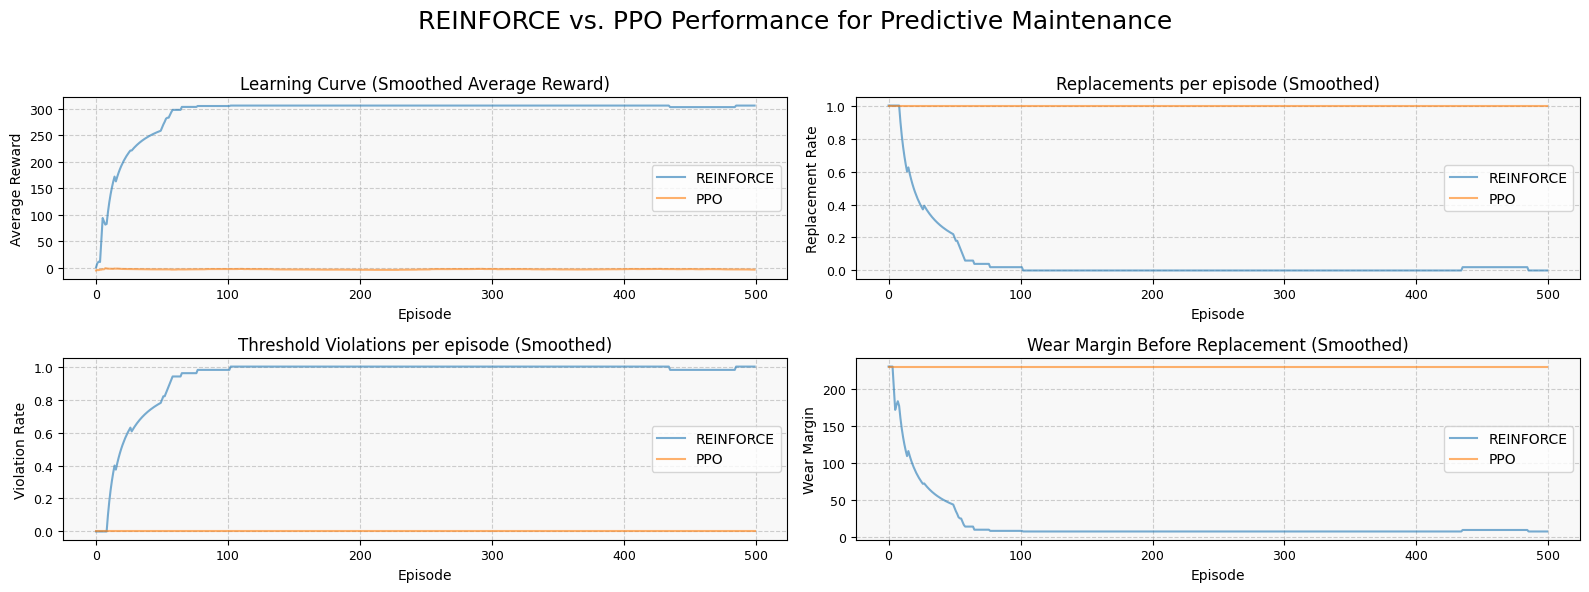

In [11]:
# For combined plots (both algorithms on same axes)
plot_metrics(reinforce_metrics, ppo_metrics, window=SMOOTH_WINDOW, mode="COMBINED")

### Test model saving and testing

In [12]:
# # Test REINFORCE model
# reinforce_metrics = test_saved_model(
#     model_file=REINFORCE_MODEL_FILE,
#     test_data_file=TEST_FILE,
#     wear_threshold=WEAR_THRESHOLD,
#     r1=R1_CONTINUE,
#     r2=R2_REPLACE,
#     r3=R3_VIOLATION,
#     model_type="REINFORCE"
# )

# # Test PPO model
# ppo_metrics = test_saved_model(
#     model_file=PPO_MODEL_FILE,  # Need to define this
#     test_data_file=TEST_FILE,
#     wear_threshold=WEAR_THRESHOLD,
#     r1=R1_CONTINUE,
#     r2=R2_REPLACE,
#     r3=R3_VIOLATION,
#     model_type="PPO"
# )

#### Utility functions

In [13]:
# import pandas as pd
# from utilities import downsample
# # Read the CSV file

# DATA = 'Case_1_1K_Data'
# DATA_TO_DOWNSAMPLE = f'data\{DATA}.csv'
# DATA_TO_DOWNSAMPLE_DS = f'data\DS_{DATA}.csv'

# df_raw = pd.read_csv(DATA_TO_DOWNSAMPLE)
# df = downsample(df_raw, 20)
# df.to_csv(DATA_TO_DOWNSAMPLE_DS, index=False)

### Environment with Attention Mechanism

In [14]:
# Create a base environment for the custom REINFORCE agent
reinforce_am_env = AM_Env(
    data_file=DATA_FILE,
    wear_threshold=WEAR_THRESHOLD,
    r1=R1_CONTINUE,
    r2=R2_REPLACE,
    r3=R3_VIOLATION)

check_env(reinforce_am_env)

In [15]:
# Train REINFORCE agent
print('\n\n Attention Based Environment: Training REINFORCE agent...')
reinforce_policy_am = PolicyNetwork(reinforce_am_env.observation_space.shape[0], reinforce_am_env.action_space.n)
reinforce_agent_am = REINFORCE(reinforce_policy_am, reinforce_am_env, learning_rate=LEARNING_RATE, gamma=GAMMA)
reinforce_metrics_am = reinforce_agent_am.learn(total_episodes=EPISODES)
print('\n -- Attention Based Environment: REINFORCE agent training complete.')



 Attention Based Environment: Training REINFORCE agent...
--- Training REINFORCE ---
Episode 50/500, Total Reward: 306.00
Episode 100/500, Total Reward: 306.00
Episode 150/500, Total Reward: 306.00
Episode 200/500, Total Reward: 306.00
Episode 250/500, Total Reward: 306.00
Episode 300/500, Total Reward: 306.00
Episode 350/500, Total Reward: 306.00
Episode 400/500, Total Reward: 306.00
Episode 450/500, Total Reward: 306.00
Episode 500/500, Total Reward: 306.00
--- Training Complete ---

 -- Attention Based Environment: REINFORCE agent training complete.


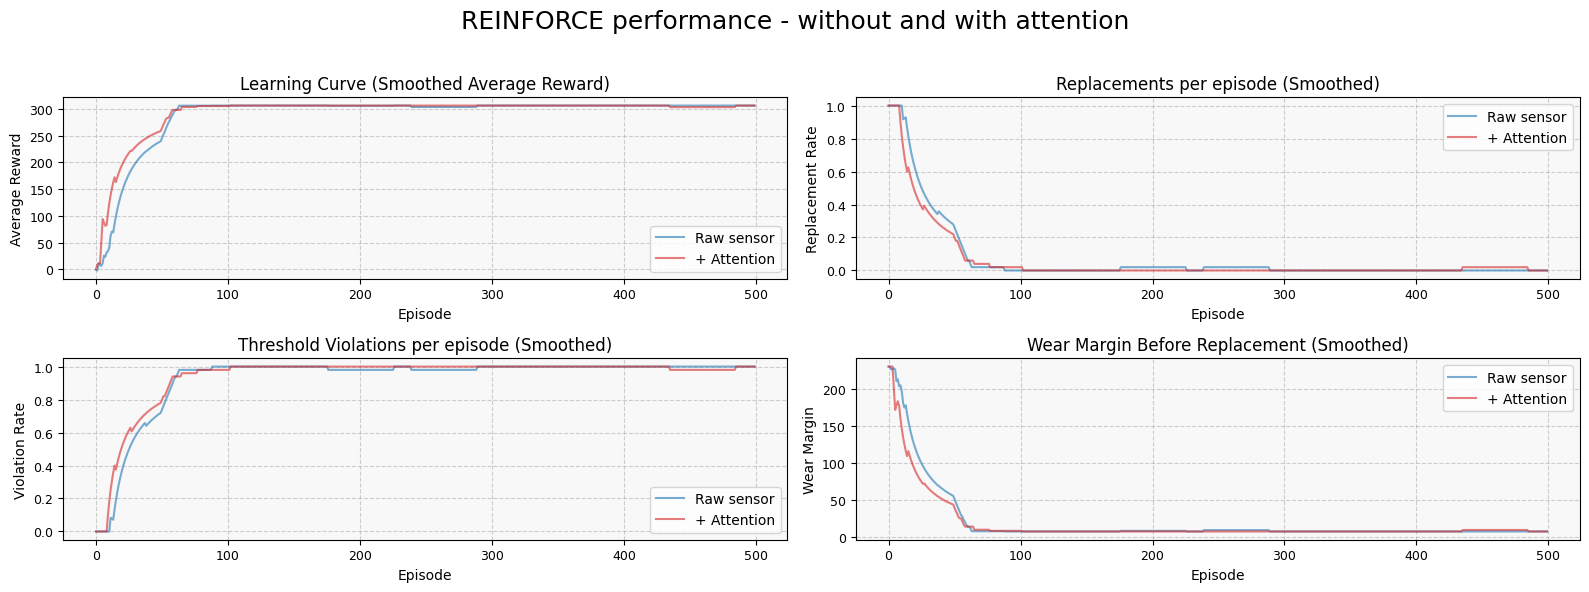

In [16]:
# For combined plots (both algorithms on same axes)
SMOOTH_WINDOW_AM = 50
plot_metrics_RF_AM(reinforce_metrics_am, reinforce_metrics, window=SMOOTH_WINDOW_AM, mode="COMBINED")